# WLS - Code Examples Part 3

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error

just some notes:

Example 1. Non-Linear Example with Y-axis Errors with Negligible Standard Deviation for the First Point

Here we assume that the Y-value for x=0 should be equal to 100, so the error for this y data point is close to zero. For the remaining points, we expect errors to be the same and equal to 0.5. Thus, standard deviation is $\sigma_{i} = 0.5$ for each data point except the first one.

We set `sigma` array as `[1e-9, 0.5, 0.5, 0.5, ...]`. The first point with `sigma = 1e-9` gets an extremely large weight, forcing the fitted curve to pass almost exactly through that point. This value is chosen to be practically zero, thereby assigning an exceptionally large weight to this data point in the minimization process, compelling the fitted curve to pass almost exactly through $(x_1, y_1)$.

Based on the results, we will see why it was a bad idea to set negligible value of the standard deviation for the first point.

## Example 1. Non-Linear Example with Y-axis Errors

`sigma` array is `[0.5, 0.5, 0.5, 0.5, ...]` for all the data points.

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error

In [91]:
# 1. Define the function to fit
def custom_function(x, A, B):
    """
    The custom function to approximate the data.
    f(x; A, B) = A * (np.exp(-B * x) - 1) + 100
    """
    return A * (np.exp(-B * x) - 1) + 100

In [92]:
# 2. Prepare the datasets
# Dataset 1
data1_x = np.array([0, 5, 25, 34, 42, 57, 97])
data1_y = np.array([100, 79.7, 51.3, 44.6, 39.8, 29.9, 10.3])

# Dataset 2
data2_x = np.array([0, 19, 45, 104, 191, 294, 391])
data2_y = np.array([100, 80.4, 66.4, 50.1, 41.2, 28.5, 20.1])

# Dataset 3
data3_x = np.array([0, 23, 51, 98, 196, 292, 401])
data3_y = np.array([100, 87.8, 77, 65.7, 50.9, 46.5, 44.4])

# Combine datasets into a list for easier iteration
datasets = [
    {"name": "Dataset 1", "x": data1_x, "y": data1_y},
    # {"name": "Dataset 2", "x": data2_x, "y": data2_y},
    # {"name": "Dataset 3", "x": data3_x, "y": data3_y},
]

In [93]:
# 3. Perform curve fitting and analysis for each dataset
results = []

for i, dataset in enumerate(datasets):
    print(f"\n--- Fitting {dataset['name']} ---")
    x_data = dataset["x"]
    y_data = dataset["y"]

    # Define sigma for Weighted Least Squares
    # First point (Y=100) has no error, assign a very small sigma to give it high weight
    # Other points have an error of +/- 0.5
    sigma = np.full_like(y_data, 0.5, dtype=float)

    # Initial guess for parameters A and B
    initial_guess = [50, 0.01]

    try:
        # curve_fit returns:
        # popt: Optimal values for the parameters so that the sum of the squared residuals is minimized.
        # pcov: The estimated covariance of popt.
        # Use sigma for weighted least squares
        popt, pcov, infodict, mesg, ier = curve_fit(custom_function, x_data, y_data, p0=initial_guess, sigma=sigma, absolute_sigma=True, full_output=True)
        A_fit, B_fit = popt

        residual_values = infodict['fvec']
        print(f"Residual values: {residual_values}")
        
        # Calculate standard errors from the covariance matrix
        perr = np.sqrt(np.diag(pcov))
        A_err, B_err = perr

        print(f"Fitted parameters: A = {A_fit:.4f} +/- {A_err:.4f}, B = {B_fit:.4f} +/- {B_err:.4f}")

        # Generate predicted y values using the fitted function
        y_predicted = custom_function(x_data, A_fit, B_fit)

        # Calculate metrics
        # Sum of Squared Residuals (SSR)
        ssr = np.sum((y_data - y_predicted)**2)
        print(f"Sum of Squared Residuals (SSR): {ssr:.4f}")

        print(np.sum(residual_values**2))

        # Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mean_squared_error(y_data, y_predicted))
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

        # Total Sum of Squares (SST)
        y_mean = np.mean(y_data)
        sst = np.sum((y_data - y_mean)**2)
        print(f"Total Sum of Squares (TSS): {sst:.4f}")

        # R-squared (Coefficient of Determination)
        r_squared = r2_score(y_data, y_predicted)
        print(f"R-squared: {r_squared:.4f}")

        # Adjusted R-squared calculation
        n = len(x_data) # Number of data points
        k = len(popt)  # Number of parameters (A, B)
        if (n - k - 1) > 0:
            adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - k - 1)
            print(f"Adjusted R-squared: {adjusted_r_squared:.4f}")
        else:
            adjusted_r_squared = np.nan
            print("Adjusted R-squared: Not applicable (insufficient degrees of freedom)")

        # Chi-Squared and Reduced Chi-Squared Calculation
        # Degrees of freedom (nu)
        nu = n - k
        if nu > 0:
            # Chi-squared (weighted sum of squared residuals)
            chi_squared = np.sum(((y_data - y_predicted) / sigma)**2)
            print(fr"Chi-Squared ($\chi^2$): {chi_squared:.4f}")

            # Reduced Chi-squared
            reduced_chi_squared = chi_squared / nu
            print(fr"Reduced Chi-Squared ($\chi^2_{{red}}$): {reduced_chi_squared:.4f}")
        else:
            chi_squared = np.nan
            reduced_chi_squared = np.nan
            print("Chi-Squared: Not applicable (insufficient degrees of freedom)")

        Value_for_x_0 = custom_function(0, A_fit, B_fit)
        print(f"Value for x=0 (Expected value is 100): {Value_for_x_0:.4f}")

        results.append({
            "name": dataset["name"],
            "x_data": x_data,
            "y_data": y_data,
            "y_predicted": y_predicted,
            "A_fit": A_fit,
            "B_fit": B_fit,
            "A_err": A_err,
            "B_err": B_err,
            "ssr": ssr,
            "rmse": rmse,
            "r_squared": r_squared,
            "adjusted_r_squared": adjusted_r_squared,
            "chi_squared": chi_squared,
            "reduced_chi_squared": reduced_chi_squared
        })

    except RuntimeError as e:
        print(f"Error: Could not fit curve for {dataset['name']}. {e}")
        results.append({
            "name": dataset["name"],
            "x_data": x_data,
            "y_data": y_data,
            "error": str(e)
        })



--- Fitting Dataset 1 ---
Residual values: [ 0.         16.99910031  5.64498518 -1.49830177 -6.41032674 -6.66143181
  5.99946257]
Fitted parameters: A = 93.5355 +/- 0.8080, B = 0.0270 +/- 0.0005
Sum of Squared Residuals (SSR): 111.1352
444.5406909552135
Root Mean Squared Error (RMSE): 3.9845
Total Sum of Squares (TSS): 5492.6000
R-squared: 0.9798
Adjusted R-squared: 0.9696
Chi-Squared ($\chi^2$): 444.5407
Reduced Chi-Squared ($\chi^2_{red}$): 88.9081
Value for x=0 (Expected value is 100): 100.0000


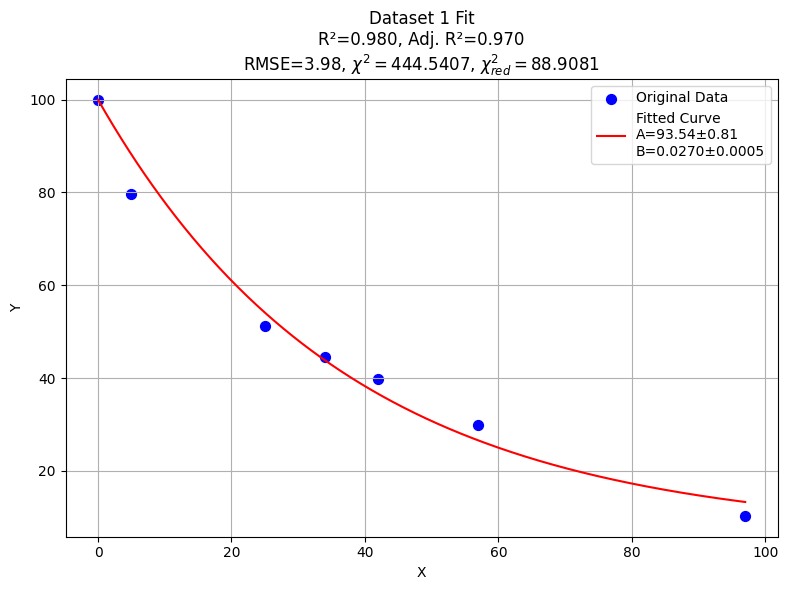

In [94]:
# 4. Plotting the results
plt.figure(figsize=(8, 6))

for i, res in enumerate(results):
    plt.subplot(len(results), 1, i + 1)
    plt.scatter(res["x_data"], res["y_data"], label="Original Data", color='blue', s=50)

    if "y_predicted" in res:
        x_plot = np.linspace(min(res["x_data"]), max(res["x_data"]), 500)
        y_plot = custom_function(x_plot, res["A_fit"], res["B_fit"])
        plt.plot(x_plot, y_plot, color='red', label=f"Fitted Curve\nA={res['A_fit']:.2f}±{res['A_err']:.2f}\nB={res['B_fit']:.4f}±{res['B_err']:.4f}")

        if not np.isnan(res['adjusted_r_squared']):
            plt.title(f"{res['name']} Fit\nR²={res['r_squared']:.3f}, Adj. R²={res['adjusted_r_squared']:.3f}\nRMSE={res['rmse']:.2f}, $\\chi^2={res['chi_squared']:.4f}$, $\\chi^2_{{red}}={res['reduced_chi_squared']:.4f}$")
        else:
            plt.title(f"{res['name']} Fit\nR²={res['r_squared']:.3f}, RMSE={res['rmse']:.2f}\nAdj. R²: N/A")
    else:
        plt.title(f"{res['name']} (Fit Error)")
        plt.text(0.5, 0.5, f"Error: {res['error']}", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, color='red')

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

### Analysis of the results

The results are totally the same as in the previous case.

It's clear that for dataset 1 and dataset 2 the results of our analysis show that the selected function doesn't fit the data well enough:
* RMSE is too high
* $\chi^2_{red}$ is too high

Thus, we need to look for another custom function for the datasets 1 and 2.

For the dataset 3:

* **Reduced Chi-Squared ($\chi^2_{red}$):** This is a measure of the **goodness-of-fit relative to our assumed measurement errors**. It normalizes the residuals by the standard deviation of the measurements ($\sigma_i$). A value close to 1 means the observed scatter of our data points around the fit is consistent with our assumed uncertainties.
    * Since $\chi^2_{red}$ is 1.4472 (greater than 1), it suggests that the scatter in our data is **larger than what we expected** based on our assumed standard deviation of 0.5. This implies that we have likely **underestimated the true measurement uncertainty**.

* **Root Mean Squared Error (RMSE):** This is an **estimate of the standard deviation of the residuals**. The fact that our RMSE (0.5084) is very close to our assumed $\sigma_i$ of 0.5 is a common occurrence and shows that our model is fitting the data well. However, because the reduced chi-squared is greater than 1, it tells us that the true underlying noise in the data is likely a bit larger than 0.5, even if the RMSE is close to that value. The $\chi^2_{red}$ is a more robust statistical tool for validating our assumption about the uncertainty of our measurements.

Let's try to increase the standard deviations from 0.5 to 1.0.

### Usage of the Higher Value of Errors

In [97]:
# 3. Perform curve fitting and analysis for each dataset
results = []

for i, dataset in enumerate(datasets):
    print(f"\n--- Fitting {dataset['name']} ---")
    x_data = dataset["x"]
    y_data = dataset["y"]

    # Define sigma for Weighted Least Squares
    # First point (Y=100) has no error, assign a very small sigma to give it high weight
    # Other points have an error of +/- 0.5
    sigma = np.full_like(y_data, 1.0, dtype=float) # UPDATE from 0.5 to 1.0
    print(f"Sigma for {dataset['name']}: {sigma}")


    # Initial guess for parameters A and B
    initial_guess = [50, 0.01]

    try:
        # curve_fit returns:
        # popt: Optimal values for the parameters so that the sum of the squared residuals is minimized.
        # pcov: The estimated covariance of popt.
        # Use sigma for weighted least squares
        popt, pcov = curve_fit(custom_function, x_data, y_data, p0=initial_guess, sigma=sigma, absolute_sigma=True)
        A_fit, B_fit = popt

        # Calculate standard errors from the covariance matrix
        perr = np.sqrt(np.diag(pcov))
        A_err, B_err = perr

        print(f"Fitted parameters: A = {A_fit:.4f} +/- {A_err:.4f}, B = {B_fit:.4f} +/- {B_err:.4f}")

        # Check condition number of the covariance matrix
        print(f"Condition number of the covariance matrix: {np.linalg.cond(pcov):.2f}")

        # Generate predicted y values using the fitted function
        y_predicted = custom_function(x_data, A_fit, B_fit)

        # Calculate metrics
        # Sum of Squared Residuals (SSR)
        ssr = np.sum((y_data - y_predicted)**2)
        print(f"Sum of Squared Residuals (SSR): {ssr:.4f}")

        # Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mean_squared_error(y_data, y_predicted))
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

        # Total Sum of Squares (SST)
        y_mean = np.mean(y_data)
        sst = np.sum((y_data - y_mean)**2)
        print(f"Total Sum of Squares (TSS): {sst:.4f}")

        # R-squared (Coefficient of Determination)
        r_squared = r2_score(y_data, y_predicted)
        print(f"R-squared: {r_squared:.4f}")

        # Adjusted R-squared calculation
        n = len(x_data) # Number of data points
        k = len(popt)  # Number of parameters (A, B)
        if (n - k - 1) > 0:
            adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - k - 1)
            print(f"Adjusted R-squared: {adjusted_r_squared:.4f}")
        else:
            adjusted_r_squared = np.nan
            print("Adjusted R-squared: Not applicable (insufficient degrees of freedom)")

        # Chi-Squared and Reduced Chi-Squared Calculation
        # Degrees of freedom (nu)
        nu = n - k
        if nu > 0:
            # Chi-squared (weighted sum of squared residuals)
            chi_squared = np.sum(((y_data - y_predicted) / sigma)**2)
            print(fr"Chi-Squared ($\chi^2$): {chi_squared:.4f}")

            # Reduced Chi-squared
            reduced_chi_squared = chi_squared / nu
            print(fr"Reduced Chi-Squared ($\chi^2_{{red}}$): {reduced_chi_squared:.4f}")
        else:
            chi_squared = np.nan
            reduced_chi_squared = np.nan
            print("Chi-Squared: Not applicable (insufficient degrees of freedom)")

        Value_for_x_0 = custom_function(0, A_fit, B_fit)
        print(f"Value for x=0 (Expected value is 100): {Value_for_x_0:.4f}")

        results.append({
            "name": dataset["name"],
            "x_data": x_data,
            "y_data": y_data,
            "y_predicted": y_predicted,
            "A_fit": A_fit,
            "B_fit": B_fit,
            "A_err": A_err,
            "B_err": B_err,
            "ssr": ssr,
            "rmse": rmse,
            "r_squared": r_squared,
            "adjusted_r_squared": adjusted_r_squared,
            "chi_squared": chi_squared,
            "reduced_chi_squared": reduced_chi_squared
        })

    except RuntimeError as e:
        print(f"Error: Could not fit curve for {dataset['name']}. {e}")
        results.append({
            "name": dataset["name"],
            "x_data": x_data,
            "y_data": y_data,
            "error": str(e)
        })



--- Fitting Dataset 1 ---
Sigma for Dataset 1: [1. 1. 1. 1. 1. 1. 1.]
Fitted parameters: A = 93.5355 +/- 1.6160, B = 0.0270 +/- 0.0010
Condition number of the covariance matrix: 17123879.75
Sum of Squared Residuals (SSR): 111.1352
Root Mean Squared Error (RMSE): 3.9845
Total Sum of Squares (TSS): 5492.6000
R-squared: 0.9798
Adjusted R-squared: 0.9696
Chi-Squared ($\chi^2$): 111.1352
Reduced Chi-Squared ($\chi^2_{red}$): 22.2270
Value for x=0 (Expected value is 100): 100.0000


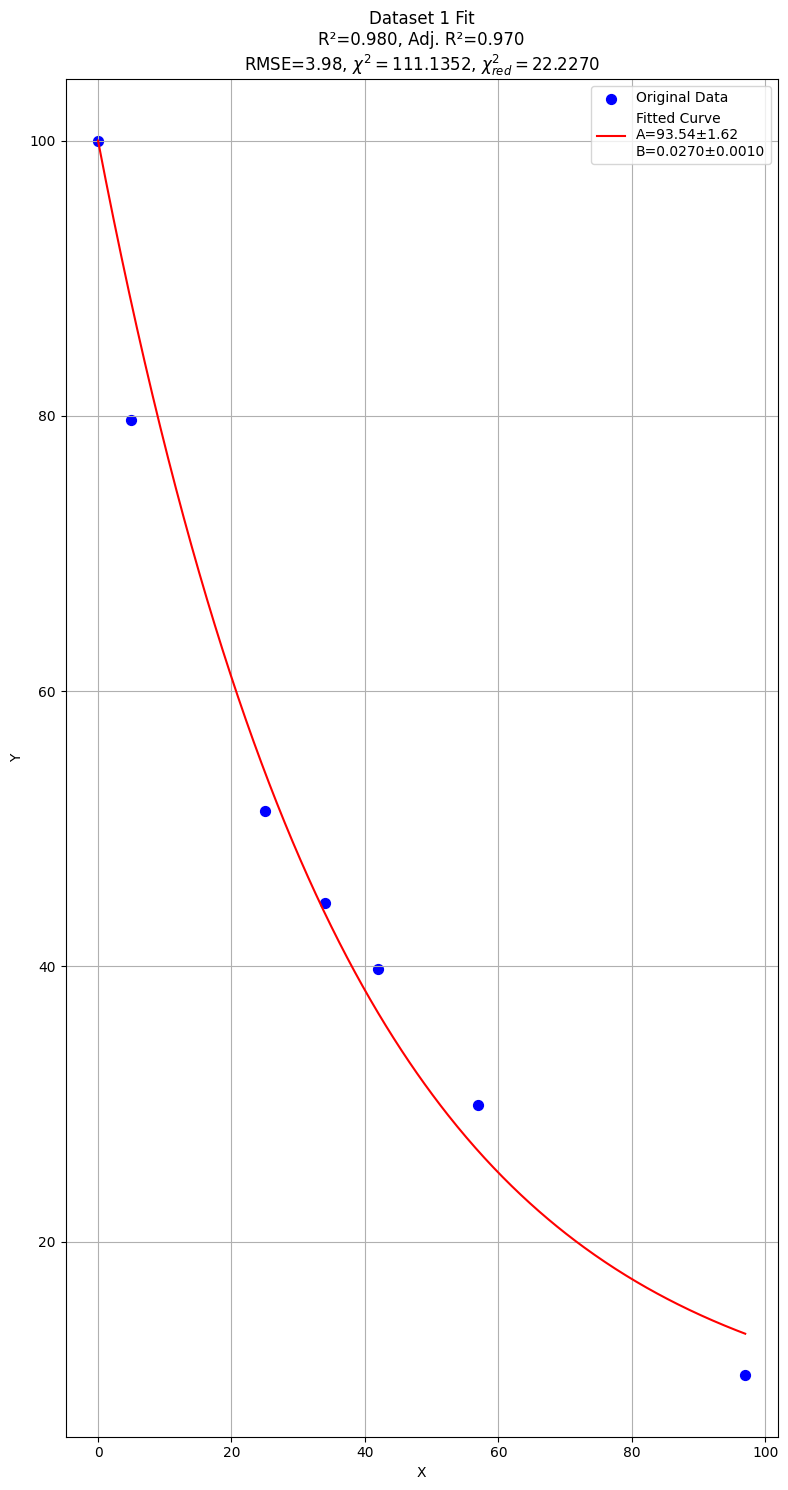

In [98]:
# 4. Plotting the results
plt.figure(figsize=(8, 15))

for i, res in enumerate(results):
    plt.subplot(len(results), 1, i + 1)
    plt.scatter(res["x_data"], res["y_data"], label="Original Data", color='blue', s=50)

    if "y_predicted" in res:
        x_plot = np.linspace(min(res["x_data"]), max(res["x_data"]), 500)
        y_plot = custom_function(x_plot, res["A_fit"], res["B_fit"])
        plt.plot(x_plot, y_plot, color='red', label=f"Fitted Curve\nA={res['A_fit']:.2f}±{res['A_err']:.2f}\nB={res['B_fit']:.4f}±{res['B_err']:.4f}")

        if not np.isnan(res['adjusted_r_squared']):
            plt.title(f"{res['name']} Fit\nR²={res['r_squared']:.3f}, Adj. R²={res['adjusted_r_squared']:.3f}\nRMSE={res['rmse']:.2f}, $\\chi^2={res['chi_squared']:.4f}$, $\\chi^2_{{red}}={res['reduced_chi_squared']:.4f}$")
        else:
            plt.title(f"{res['name']} Fit\nR²={res['r_squared']:.3f}, RMSE={res['rmse']:.2f}\nAdj. R²: N/A")
    else:
        plt.title(f"{res['name']} (Fit Error)")
        plt.text(0.5, 0.5, f"Error: {res['error']}", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, color='red')

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

Results for the dataset 1 and 2:
* RMSE is too high
* $\chi^2_{red}$ is too high

Results for the dataset 3:
* A reduced chi-squared value of 0.3618 is too low and indicates that we have overestimated the standard deviation of our measurements.
* Also, note that the errors for A and B parameters were increased afrer we increased

The standard deviation of 0.6 will make $\chi^2_{red}$ very close to 1 for the dataset 3 (see below)

In [99]:
# 3. Perform curve fitting and analysis for each dataset
results = []

for i, dataset in enumerate(datasets):
    print(f"\n--- Fitting {dataset['name']} ---")
    x_data = dataset["x"]
    y_data = dataset["y"]

    # Define sigma for Weighted Least Squares
    # First point (Y=100) has no error, assign a very small sigma to give it high weight
    # Other points have an error of +/- 0.5
    sigma = np.full_like(y_data, 0.6, dtype=float) # UPDATE from 1.0 to 0.6
    print(f"Sigma for {dataset['name']}: {sigma}")


    # Initial guess for parameters A and B
    initial_guess = [50, 0.01]

    try:
        # curve_fit returns:
        # popt: Optimal values for the parameters so that the sum of the squared residuals is minimized.
        # pcov: The estimated covariance of popt.
        # Use sigma for weighted least squares
        popt, pcov = curve_fit(custom_function, x_data, y_data, p0=initial_guess, sigma=sigma, absolute_sigma=True)
        A_fit, B_fit = popt

        # Calculate standard errors from the covariance matrix
        perr = np.sqrt(np.diag(pcov))
        A_err, B_err = perr

        print(f"Fitted parameters: A = {A_fit:.4f} +/- {A_err:.4f}, B = {B_fit:.4f} +/- {B_err:.4f}")

        # Check condition number of the covariance matrix
        print(f"Condition number of the covariance matrix: {np.linalg.cond(pcov):.2f}")

        # Generate predicted y values using the fitted function
        y_predicted = custom_function(x_data, A_fit, B_fit)

        # Calculate metrics
        # Sum of Squared Residuals (SSR)
        ssr = np.sum((y_data - y_predicted)**2)
        print(f"Sum of Squared Residuals (SSR): {ssr:.4f}")

        # Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mean_squared_error(y_data, y_predicted))
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

        # Total Sum of Squares (SST)
        y_mean = np.mean(y_data)
        sst = np.sum((y_data - y_mean)**2)
        print(f"Total Sum of Squares (TSS): {sst:.4f}")

        # R-squared (Coefficient of Determination)
        r_squared = r2_score(y_data, y_predicted)
        print(f"R-squared: {r_squared:.4f}")

        # Adjusted R-squared calculation
        n = len(x_data) # Number of data points
        k = len(popt)  # Number of parameters (A, B)
        if (n - k - 1) > 0:
            adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - k - 1)
            print(f"Adjusted R-squared: {adjusted_r_squared:.4f}")
        else:
            adjusted_r_squared = np.nan
            print("Adjusted R-squared: Not applicable (insufficient degrees of freedom)")

        # Chi-Squared and Reduced Chi-Squared Calculation
        # Degrees of freedom (nu)
        nu = n - k
        if nu > 0:
            # Chi-squared (weighted sum of squared residuals)
            chi_squared = np.sum(((y_data - y_predicted) / sigma)**2)
            print(fr"Chi-Squared ($\chi^2$): {chi_squared:.4f}")

            # Reduced Chi-squared
            reduced_chi_squared = chi_squared / nu
            print(fr"Reduced Chi-Squared ($\chi^2_{{red}}$): {reduced_chi_squared:.4f}")
        else:
            chi_squared = np.nan
            reduced_chi_squared = np.nan
            print("Chi-Squared: Not applicable (insufficient degrees of freedom)")

        Value_for_x_0 = custom_function(0, A_fit, B_fit)
        print(f"Value for x=0 (Expected value is 100): {Value_for_x_0:.4f}")

        results.append({
            "name": dataset["name"],
            "x_data": x_data,
            "y_data": y_data,
            "y_predicted": y_predicted,
            "A_fit": A_fit,
            "B_fit": B_fit,
            "A_err": A_err,
            "B_err": B_err,
            "ssr": ssr,
            "rmse": rmse,
            "r_squared": r_squared,
            "adjusted_r_squared": adjusted_r_squared,
            "chi_squared": chi_squared,
            "reduced_chi_squared": reduced_chi_squared
        })

    except RuntimeError as e:
        print(f"Error: Could not fit curve for {dataset['name']}. {e}")
        results.append({
            "name": dataset["name"],
            "x_data": x_data,
            "y_data": y_data,
            "error": str(e)
        })



--- Fitting Dataset 1 ---
Sigma for Dataset 1: [0.6 0.6 0.6 0.6 0.6 0.6 0.6]
Fitted parameters: A = 93.5355 +/- 0.9696, B = 0.0270 +/- 0.0006
Condition number of the covariance matrix: 17123881.30
Sum of Squared Residuals (SSR): 111.1352
Root Mean Squared Error (RMSE): 3.9845
Total Sum of Squares (TSS): 5492.6000
R-squared: 0.9798
Adjusted R-squared: 0.9696
Chi-Squared ($\chi^2$): 308.7088
Reduced Chi-Squared ($\chi^2_{red}$): 61.7418
Value for x=0 (Expected value is 100): 100.0000


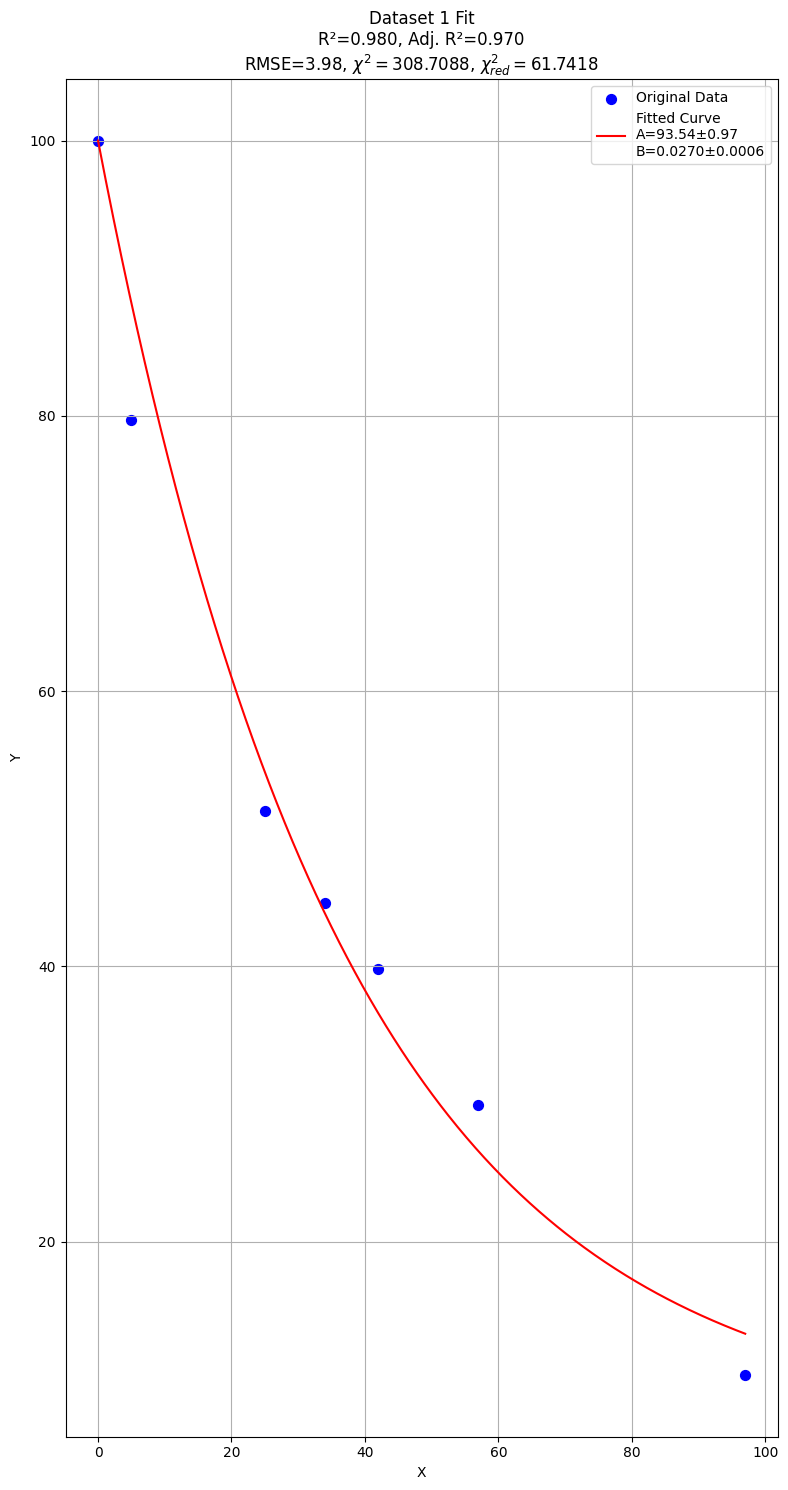

In [100]:
# 4. Plotting the results
plt.figure(figsize=(8, 15))

for i, res in enumerate(results):
    plt.subplot(len(results), 1, i + 1)
    plt.scatter(res["x_data"], res["y_data"], label="Original Data", color='blue', s=50)

    if "y_predicted" in res:
        x_plot = np.linspace(min(res["x_data"]), max(res["x_data"]), 500)
        y_plot = custom_function(x_plot, res["A_fit"], res["B_fit"])
        plt.plot(x_plot, y_plot, color='red', label=f"Fitted Curve\nA={res['A_fit']:.2f}±{res['A_err']:.2f}\nB={res['B_fit']:.4f}±{res['B_err']:.4f}")

        if not np.isnan(res['adjusted_r_squared']):
            plt.title(f"{res['name']} Fit\nR²={res['r_squared']:.3f}, Adj. R²={res['adjusted_r_squared']:.3f}\nRMSE={res['rmse']:.2f}, $\\chi^2={res['chi_squared']:.4f}$, $\\chi^2_{{red}}={res['reduced_chi_squared']:.4f}$")
        else:
            plt.title(f"{res['name']} Fit\nR²={res['r_squared']:.3f}, RMSE={res['rmse']:.2f}\nAdj. R²: N/A")
    else:
        plt.title(f"{res['name']} (Fit Error)")
        plt.text(0.5, 0.5, f"Error: {res['error']}", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, color='red')

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()